In [0]:
%matplotlib inline
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import os
from sklearn.preprocessing import StandardScaler

## Create a function that will extract the data from the dataset
Inside `cifar-10-batches-py`folder we have <br>
1. data_batch_x files <br>
2. test_batch 

The data_batch_x files are the batched training data splited in x parts (in our case in 5 parts of 10000 samples each). The test_batch file contains 10000 samples for testing.

There is also another file called batches.meta where it describes the classes

In [0]:
# Function to unpickle the dataset
def unpickle_all_data(directory):
    
    # Initialize the variables
    train = dict()
    test = dict()
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    # Iterate through all files that we want, train and test
    # Train is separated into batches
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            
            # The train data
            if 'data_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Opent the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo)

                if 'data' not in train:
                    train['data'] = data[b'data']
                    train['labels'] = np.array(data[b'labels'])
                else:
                    train['data'] = np.concatenate((train['data'], data[b'data']))
                    train['labels'] = np.concatenate((train['labels'], data[b'labels']))
            # The test data
            elif 'test_batch' in filename:
                print('Handing file: %s' % filename)
                
                # Open the file
                with open(directory + '/' + filename, 'rb') as fo:
                    data = pickle.load(fo)
                
                test['data'] = data[b'data']
                test['labels'] = data[b'labels']
    
    # Manipulate the data to the propper format
    for image in train['data']:
        train_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    train_y = [label for label in train['labels']]
    
    for image in test['data']:
        test_x.append(np.transpose(np.reshape(image,(3, 32,32)), (1,2,0)))
    test_y = [label for label in test['labels']]
    
    # Transform the data to np array format
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    return (train_x, train_y), (test_x, test_y)

## Using the function

Returns four variables
1. x_train := A 3D numpy array with the images in a format (32, 32, 3) a 32x32 image with 3 dimmesions for colors RGB
2. y_train := A 1D numpy with the numbered labels for each sample stom x_train
3. x_test := same as x_train
4. y_test := same as y_train

In [6]:
from keras.datasets import cifar10 
#called function to unpickle data to test and train features and labels
#(x_train, y_train), (x_test, y_test) = unpickle_all_data(os.getcwd() + '/cifar-10-batches-py/')
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

Using TensorFlow backend.


170508288/170498071 [==============================] - 46s 0us/step


##  Data Preprocessing

In [0]:
from keras.utils import np_utils

# Transform them to a float32 type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the input data 
x_train /= 255
x_test /= 255

# One-hot Encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## Model creation
2 convolution layers and 2 Fully connected layers used with<br>
    1)Batch Normalization<br>
    2)Relu activation function<br>
    3)Adam optimizer-adaptive moment estimation.<br>
    4)Dropout to prevent overfitting<br>
You can try different layouts to improve the accuracy

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

## Augment the data
From one sample, extract multiple versions
For example, rotate the image, shift, flip etc
Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

In [0]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

## Compiling the model

In [0]:
# Compile the model
batch_size = 64

#opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6) for momentum instead of adam use oppt_rms
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Plot

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Training the algorithm
I would suggest more than 100 epochs

In [13]:
import time
start=time.time()
epochs = 50
model_info=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
end=time.time()

Epoch 1/50
781/781 [==============================] - 35s 44ms/step - loss: 1.6438 - acc: 0.4206 - val_loss: 1.3060 - val_acc: 0.5465
Epoch 2/50
781/781 [==============================] - 32s 41ms/step - loss: 1.2548 - acc: 0.5465 - val_loss: 1.0886 - val_acc: 0.6190
Epoch 3/50
781/781 [==============================] - 31s 39ms/step - loss: 1.1449 - acc: 0.5915 - val_loss: 1.1304 - val_acc: 0.5996
Epoch 4/50
781/781 [==============================] - 33s 42ms/step - loss: 1.0868 - acc: 0.6140 - val_loss: 0.9088 - val_acc: 0.6749
Epoch 5/50
781/781 [==============================] - 32s 41ms/step - loss: 1.0305 - acc: 0.6343 - val_loss: 0.8943 - val_acc: 0.6900
Epoch 6/50
781/781 [==============================] - 31s 39ms/step - loss: 1.0016 - acc: 0.6470 - val_loss: 0.9390 - val_acc: 0.6701
Epoch 7/50
781/781 [==============================] - 31s 40ms/step - loss: 0.9729 - acc: 0.6561 - val_loss: 1.0314 - val_acc: 0.6360
Epoch 8/50
781/781 [==============================] - 30s 39ms

In [14]:
end-start

1532.4279251098633

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

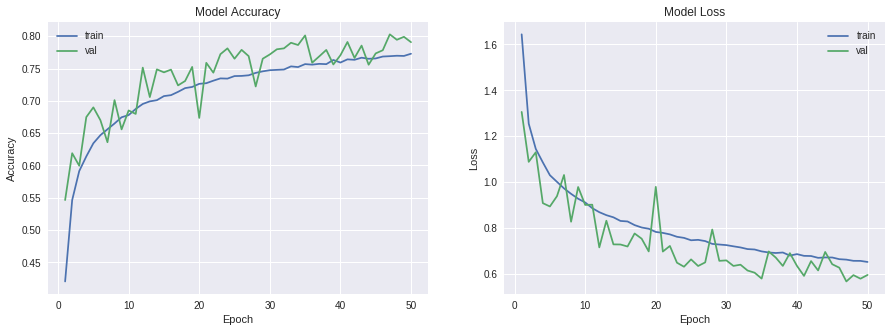

Model took 1532.43 seconds to train
Accuracy on test data is: 79.09


In [16]:
import matplotlib.pyplot as plt
# plot model history
plot_model_history(model_info)
print "Model took %0.2f seconds to train"%(end - start)
# compute test accuracy
print "Accuracy on test data is: %0.2f"%accuracy(x_test, y_test, model)